# CEO-Request Challenge


🕵🏻 **Should Olist remove underperforming sellers from its marketplace ?**

## Problem statement

🕵🏻 To analyse the impact of removing the worse sellers from Olist's marketplace, we can start with a what-if analysis: What would have happened if Olist had never accepted these sellers in the first place? For that:

1️⃣ Compute, for each `seller_id`, and cumulated since the beginning:
- the `revenues` it brings
- the `costs` associated with all its bad reviews
- the resulting `profits` (revenues - costs)
- the number of `orders` (it will impact the overall IT costs)


2️⃣ We can then:
- sort sellers by increasing profits for Olist
- for each number of sellers to remove, compute the financial impact it would have made if they had never been accepted on the platform. 
- we may find an optimal number of sellers to remove that maximizes Olist's profit margin

👉 Write down a detailed strategy (step by step) to create the DataFrame you need for the first step.

💡Think about how to re-use or update the logic you've already coded in your 🗂 `olist` package

<details>
    <summary>- <i>Hints</i> -</summary>


Starting from your current `seller().get_training_data()` DataFrame, can you easily transform it to compute:
- Olist's positive `revenue_per_seller`? 
- Olist's `cost_of_bad_reviews`?

⚠️ Do no start from scratch ! Investigate your source code in `seller.py` : 
- how was the mean `review_score` per seller computed? 
- Can you think about  a way to update your code to incorporate the `cost_of_reviews`? 

</details>


## Imports

🧺 Keep this notebook tidy! 

📅 🗣 📊 You will present your insights to Olist's CEO next time, after the `Communicate your Data Analysis insights` day!

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [6]:
from olist.seller import Seller
seller = Seller()

In [7]:
sellers = seller.get_training_data()
sellers.head(3)

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,share_of_one_stars,share_of_five_stars,review_score,n_orders,quantity,quantity_per_order,sales
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.0,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,0.333333,0.333333,3.00,3,3,1.000,218.70
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.0,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,0.050000,0.725000,4.55,40,41,1.025,11703.07
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.0,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.000000,1.000000,5.00,1,1,1.000,158.00


## Revenues

In [8]:
sellers['commission'] = sellers.sales * 0.1
sellers.head(3)

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,share_of_one_stars,share_of_five_stars,review_score,n_orders,quantity,quantity_per_order,sales,commission
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.0,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,0.333333,0.333333,3.00,3,3,1.000,218.70,21.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.0,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,0.050000,0.725000,4.55,40,41,1.025,11703.07,1170.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.0,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.000000,1.000000,5.00,1,1,1.000,158.00,15.800


In [9]:
sellers['subscription'] = np.floor((sellers.date_last_sale - sellers.date_first_sale).dt.days / 365 * 12 + 1) * 80

In [10]:
sellers['revenue'] = sellers['subscription'] + sellers['commission']

In [11]:
sellers.columns

Index(['seller_id', 'seller_city', 'seller_state', 'delay_to_carrier',
       'wait_time', 'date_first_sale', 'date_last_sale', 'share_of_one_stars',
       'share_of_five_stars', 'review_score', 'n_orders', 'quantity',
       'quantity_per_order', 'sales', 'commission', 'subscription', 'revenue'],
      dtype='object')

## Orders Reviews

In [12]:
from olist.order import Order
order = Order()
orders = order.get_review_score().copy()
orders.head(3)

,order_id,dim_is_five_star,dim_is_one_star,review_score
0,73fc7af87114b39712e6da79b0a377eb,0,0,4
1,a548910a1c6147796b98fdf73dbeba33,1,0,5
2,f9e4b658b201a9f2ecdecbb34bed034b,1,0,5


In [13]:
def cost_calculator(score):
    if score == 1:
        return 100
    if score == 2:
        return 50
    if score == 3:
        return 40
    return 0

In [14]:
orders['cost'] = orders.review_score.apply(cost_calculator)
orders = orders[['order_id', 'cost']]
orders

,order_id,cost
0,73fc7af87114b39712e6da79b0a377eb,0
1,a548910a1c6147796b98fdf73dbeba33,0
2,f9e4b658b201a9f2ecdecbb34bed034b,0
3,658677c97b385a9be170737859d3511b,0
4,8e6bfb81e283fa7e4f11123a3fb894f1,0
...,...,...
99219,2a8c23fee101d4d5662fa670396eb8da,0
99220,22ec9f0669f784db00fa86d035cf8602,0
99221,55d4004744368f5571d1f590031933e4,0
99222,7725825d039fc1f0ceb7635e3f7d9206,0


## Sellers  Costs

In [15]:
sellers_cost = seller.matching_table.merge(orders, on='order_id')\
                     .groupby('seller_id', as_index=False)\
                     .sum()

In [16]:
sellers = sellers.merge(sellers_cost, on='seller_id')
sellers.head(3)

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,share_of_one_stars,share_of_five_stars,review_score,n_orders,quantity,quantity_per_order,sales,commission,subscription,revenue,cost
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.0,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,0.333333,0.333333,3.00,3,3,1.000,218.70,21.870,320.0,341.870,140
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.0,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,0.050000,0.725000,4.55,40,41,1.025,11703.07,1170.307,1200.0,2370.307,240
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.0,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.000000,1.000000,5.00,1,1,1.000,158.00,15.800,80.0,95.800,0


In [17]:
sellers['profit'] = sellers.revenue - sellers.cost
sellers.head()

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,share_of_one_stars,share_of_five_stars,review_score,n_orders,quantity,quantity_per_order,sales,commission,subscription,revenue,cost,profit
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,0.333333,0.333333,3.00,3,3,1.000,218.70,21.870,320.0,341.870,140,201.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,0.050000,0.725000,4.55,40,41,1.025,11703.07,1170.307,1200.0,2370.307,240,2130.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.000000,1.000000,5.00,1,1,1.000,158.00,15.800,80.0,95.800,0,95.800
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.000000,1.000000,5.00,1,1,1.000,79.99,7.999,80.0,87.999,0,87.999
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,1.000000,0.000000,1.00,1,1,1.000,167.99,16.799,80.0,96.799,100,-3.201


In [18]:
sellers[['seller_id', 'profit']].sort_values('profit', ascending=False)

,seller_id,profit
868,53243585a1d6dc2643021fd1853d8905,18067.605
67,7e93a43ef30c4f03f38b393420bc753a,14663.187
534,fa1c13f2614d7b5c4749cbc52fecda94,14494.203
2151,edb1ef5e36e0c8cd84eb3c9b003e486d,7288.455
2830,46dc3b2cc0980fb8ec44634e21d2718e,7151.119
...,...,...
315,8b321bb669392f5163d04c59e235e066,-13136.431
945,ea8482cd71df3c1969d7b9473ff13abc,-16632.248
1357,cc419e0650a3c5ba77189a1882b7556a,-19281.158
2358,4a3ca9315b744ce9f8e9374361493884,-20692.708


## IT Costs

In [19]:
cumulated_it_costs = 500000
cumulated_orders = sellers.n_orders.sum()
cumulated_orders

99841

In [20]:
def it_square(orders):
    return ((orders / cumulated_orders) ** 0.5) * cumulated_it_costs

## Summary

In [21]:
sellers[['seller_id', 'review_score', 'quantity', 'sales', 'commission', 'subscription', 'revenue', 'cost', 'profit']]

,seller_id,review_score,quantity,sales,commission,subscription,revenue,cost,profit
0,3442f8959a84dea7ee197c632cb2df15,3.00,3,218.70,21.870,320.0,341.870,140,201.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,4.55,41,11703.07,1170.307,1200.0,2370.307,240,2130.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,5.00,1,158.00,15.800,80.0,95.800,0,95.800
3,c0f3eea2e14555b6faeea3dd58c1b1c3,5.00,1,79.99,7.999,80.0,87.999,0,87.999
4,51a04a8a6bdcb23deccc82b0b80742cf,1.00,1,167.99,16.799,80.0,96.799,100,-3.201
...,...,...,...,...,...,...,...,...,...
2962,98dddbc4601dd4443ca174359b237166,5.00,2,158.00,15.800,80.0,95.800,0,95.800
2963,f8201cab383e484733266d1906e2fdfa,4.10,10,889.00,88.900,1120.0,1208.900,140,1068.900
2964,74871d19219c7d518d0090283e03c137,5.00,7,550.04,55.004,400.0,455.004,0,455.004
2965,e603cf3fec55f8697c9059638d6c8eb5,4.25,11,297.00,29.700,400.0,429.700,50,379.700


In [22]:
total_profits = sellers.profit.sum()
net_profits = total_profits - cumulated_it_costs
net_profits

716708.4440000001

In [23]:
number_of_sellers = sellers.seller_id.count()
number_of_sellers

2967

In [24]:
def total_profits_func(sellers_to_remove):
    new_sellers = sellers.sort_values(by='profit').tail(number_of_sellers - sellers_to_remove)
    return new_sellers.profit.sum() - it_square(new_sellers.n_orders.sum())
totals = []
for i in range(0, 500):
    totals.append(total_profits_func(i))

In [25]:
max(totals)

1182507.180365663

In [26]:
totals.index(1182507.180365663)

329

In [27]:
total_profits_func(50)

1074578.8318437594

## Graphs

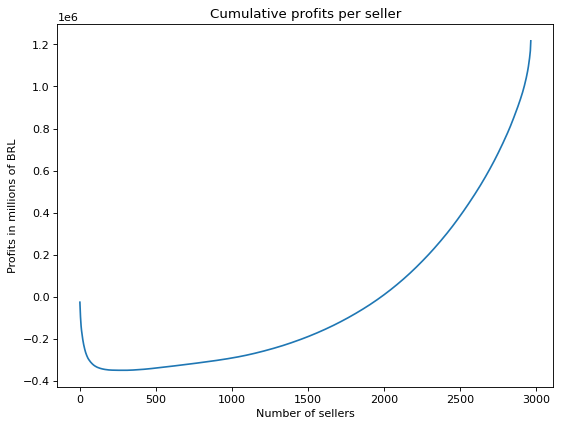

In [28]:
plt.figure(figsize=(8, 6), dpi=80)
plt.title('Cumulative profits per seller')
plt.xlabel("Number of sellers")
plt.ylabel("Profits in millions of BRL")
np.cumsum(sellers.sort_values(by='profit').profit.reset_index(drop=True)).plot();

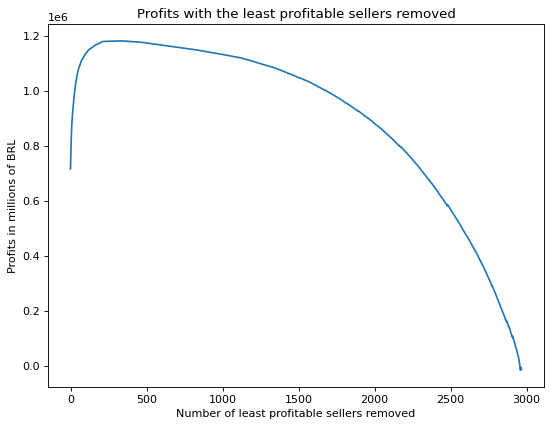

In [35]:
x = range(0, 2967)
y = [total_profits_func(i) for i in x]
plt.figure(figsize=(8, 6), dpi=80)
plt.title('Profits with the least profitable sellers removed')
plt.xlabel("Number of least profitable sellers removed")
plt.ylabel("Profits in millions of BRL")
plt.plot(x, y);

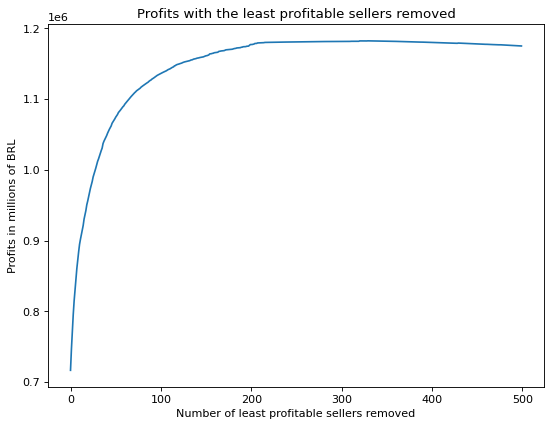

In [36]:
x = range(0, 500)
y = [total_profits_func(i) for i in x]
plt.figure(figsize=(8, 6), dpi=80)
plt.title('Profits with the least profitable sellers removed')
plt.xlabel("Number of least profitable sellers removed")
plt.ylabel("Profits in millions of BRL")
plt.plot(x, y);

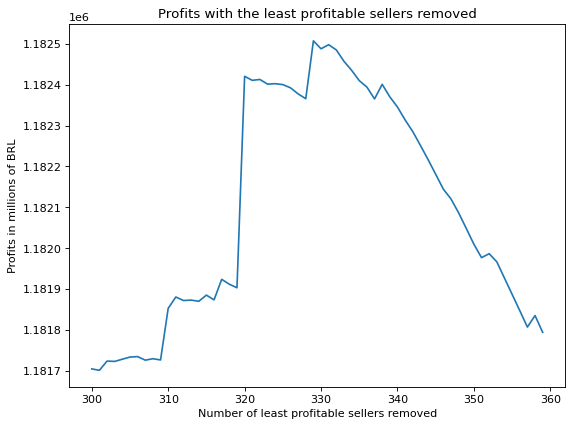

In [31]:
x = range(300, 360)
y = [total_profits_func(i) for i in x]
plt.figure(figsize=(8, 6), dpi=80)
plt.title('Profits with the least profitable sellers removed')
plt.xlabel("Number of least profitable sellers removed")
plt.ylabel("Profits in millions of BRL")
plt.plot(x, y);

In [32]:
sellers[['seller_id', 'wait_time', 'date_first_sale', 'date_last_sale', 'review_score', 'quantity', 'sales', 'commission', 'subscription', 'revenue', 'cost', 'profit']]\
        .sort_values(by='quantity', ascending = False)\
        .head(5)

,seller_id,wait_time,date_first_sale,date_last_sale,review_score,quantity,sales,commission,subscription,revenue,cost,profit
769,6560211a19b47992c3666cc44a7e94c0,9.539486,2017-02-17 07:45:11,2018-08-29 09:25:12,3.937093,2033,123304.83,12330.483,1520.0,13850.483,38880,-25029.517
2358,4a3ca9315b744ce9f8e9374361493884,14.416471,2017-01-08 09:45:12,2018-08-27 11:04:18,3.827873,1987,200472.92,20047.292,1600.0,21647.292,42340,-20692.708
453,1f50f920176fa81dab994f9023523100,15.571831,2017-04-03 22:15:14,2018-08-28 03:45:18,4.130342,1931,106939.21,10693.921,1360.0,12053.921,24400,-12346.079
1357,cc419e0650a3c5ba77189a1882b7556a,11.539753,2017-02-02 17:10:21,2018-08-28 03:45:15,4.077586,1775,104288.42,10428.842,1520.0,11948.842,31230,-19281.158
1799,da8622b14eb17ae2831f4ac5b9dab84a,11.169687,2017-02-05 22:02:04,2018-08-28 22:10:12,4.178868,1551,160236.57,16023.657,1520.0,17543.657,23080,-5536.343


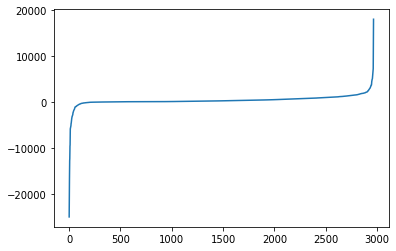

In [33]:
sellers.sort_values(by='profit').profit.reset_index(drop=True).plot();

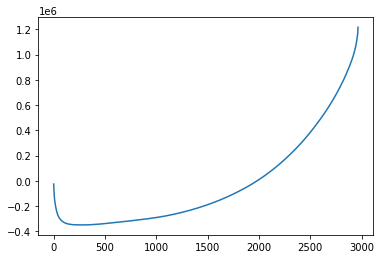

In [34]:
np.cumsum(sellers.sort_values(by='profit').profit.reset_index(drop=True)).plot();